# Notebook to run synthetic experiments

In [1]:
%load_ext autoreload

%autoreload 2
from SBMs.experiments import * 

from models.models import *
from utils.utils import *
from tqdm import tqdm

In [60]:

node_features =num_features= 64
num_communities = 4
layers = 1
dropout = .5
device = torch.device("mps")
experiment_name = 'Community Split'
training_runs = 500
evaluation_runs = 500
n = 1000

epochs = 5
edge_counts = np.array([18*n,6*2 * n])
pi  = [1,1,1,1]
prop_mat = np.array([[18,2,2,2],[2,18,2,2] ,[2,2,18,2],[2,2,2,18]])

lr = .001 
weight_decay = .0005
if experiment_name == 'Change of Attribute':
    attribute = 'prop_mat'
    changed_value = np.array([[17,2,2,2],[2,17,2,2] ,[2,2,17,2],[2,2,2,17]])

    


gravity = 4
num_edges = edge_counts.sum()
set_seeds(0)


    


model = GCN_Cluster(node_feature_dim=node_features,num_communities=num_communities,layers=layers,dropout=dropout)
model.to(device)
#takes is as inputs above configurations

def generate_data(experiment_name,n,num_features,device,training_runs,evaluation_runs,change_point = None,make_plot= False,iter = 0):

    experiment:Experiment = get_experiment(experiment_name)( 
                                                  n = n,
                                                  num_edges = num_edges,
                                                  in_degree = 18,
                                                  out_degree = 2,
                                                  pi = pi,
                                                  prop_mat = prop_mat,
                                                  num_features = num_features,
                                                  degree_law = 'power')

    datas = []
    memberships = []
    changed_values = [np.array([[17, 3, 3, 3], [3, 17, 3, 3], [3, 3, 17, 3], [3, 3, 3, 17]])]
                    

    # Additional values to be added to make the entries uniform
    additional_values = [
        [16, 4], 
        [15, 5], 
        [14, 6], 
        [13, 7], 
        [12, 8], 
        [11, 9], 
        [10, 10]
    ]
     # Iterate to complete the uniform pattern
    for vals in additional_values:
        last_element = changed_values[-1]
        max_value = np.max(last_element)
        new_array = last_element.copy()

        # Decrease the maximum value by one and increase the rest by one
        new_array[new_array == max_value] = vals[0]
        new_array[new_array != vals[0]] = vals[1]

        # Add the new array to the list
        changed_values.append(new_array)

    changed_value = changed_values[iter]
    print(f"==>> {changed_value=}")
    print(f"==>> {iter=}")


    datas.append(experiment.make_data(device))
    num_runs = training_runs + evaluation_runs
    memberships.append(experiment.G.graph_memberships)
    sample_centers = []
    for ts in (pbar := tqdm(range(num_runs))):
            if change_point is not None and change_point == (ts+1) and experiment_name != 'No Change':
                if experiment_name == 'Abrupt Covariate Shift':
                    experiment.change(gravity = gravity)
                if experiment_name == 'Change of Attribute':
                    experiment.change() if experiment_name != 'Change of Attribute' else experiment.change(attribute = attribute, new_value = changed_value)
                else:
                    experiment.change()
                    print('changed')
            if experiment_name == 'Gradual Covariate Shift' and change_point < (ts+1):
                experiment.change(step =10)
                # print(ts)

            experiment.resample_graph()
            datas.append(experiment.make_data(device))
            memberships.append(experiment.G.graph_memberships)
            sample_centers.append(experiment.G.node_features_centers[0])
    plt.plot(range(num_runs),sample_centers) if make_plot  else None
    return datas,memberships
        
        
        
    
    
def train_model(datas,loss_function,memberships,optimizer,model,training_runs, epochs,num_prints = 1,pbar = None):
    modularity_losses = []
    regularization_losses = []  
    training_nmis = []
    validation_nmis = [] 
    validation_modularity_losses = []
    validation_regularization_losses = []
    every = int(epochs / num_prints)

  
    
    for i in range(epochs):
        for ts in range(training_runs):
            optimizer.zero_grad()
            x,edge_index,A = datas[ts]
            C = model(x,A)
    
            modularity_loss, regularization_loss = loss_function(A,C)
            loss = modularity_loss + regularization_loss
            loss.backward()
            optimizer.step()
            modularity_losses.append(modularity_loss.item())
            regularization_losses.append(regularization_loss.item())
            
            C = np.argmax( C.detach().cpu().numpy(),axis=1)
            training_nmi = normalized_mutual_info_score(C,memberships[ts])
            training_nmis.append(training_nmi)
            

        if  1:

            #calculate validation loss
            model.eval()
            #calculate training nmi 
            C = model(x,A)
            validation_modularity_loss , validation_regularization_loss = loss_function(A,C)
            validation_modularity_losses.append(validation_modularity_loss.item())
            validation_regularization_losses.append(validation_regularization_loss.item())
            C = np.argmax( C.detach().cpu().numpy(),axis=1)
            val_nmi = normalized_mutual_info_score(C,memberships[ts])
            validation_nmis.append(val_nmi)
            model.train()
            print(f"Epoch {i} | Loss {loss.item():.2f}| Training NMI {training_nmi:.2f} |Val NMI {val_nmi:.2f} | Val Loss {validation_modularity_loss.item():.2f} |  Modularity Loss {validation_modularity_loss.item():.2f} | Regularization Loss {regularization_loss.item():.10f} | LR {lr}") if pbar is None else pbar.set_description(f"Epoch {i} | Loss {loss.item():.2f}| Training NMI {training_nmi:.2f} |Val NMI {val_nmi:.2f} | Val Loss {validation_modularity_loss.item():.2f} |  Modularity Loss {validation_modularity_loss.item():.2f} | Regularization Loss {regularization_loss.item():.10f} | LR {lr}") 

            
            
    return modularity_losses,regularization_losses,training_nmis,validation_nmis,validation_modularity_losses,validation_regularization_losses
            



   
def train_model(datas,loss_function,memberships,optimizer,model,training_runs, epochs,num_prints = 1,pbar = None):
    modularity_losses = []
    regularization_losses = []  
    training_nmis = []
    validation_nmis = [] 
    validation_modularity_losses = []
    validation_regularization_losses = []
    every = int(epochs / num_prints)

  
    
    for i in range(epochs):
        for ts in range(training_runs):
            optimizer.zero_grad()
            x,edge_index,A = datas[ts]

    
            modularity_loss, regularization_loss = loss_function(A,C)
            loss = modularity_loss + regularization_loss
            loss.backward()
            optimizer.step()
            modularity_losses.append(modularity_loss)
            regularization_losses.append(regularization_loss.item())
            

            

            
            
    return modularity_losses
            
        
        

            
def evaluate_model(datas,loss_function, memberships,model,training_runs,evaluation_runs, every = 10):
    model.eval()
    
    evaluation_losses_reg = []
    evaluation_losses_mod = []
    evaluation_nmis = []
    

            
    for ts in range(training_runs,evaluation_runs+training_runs):
            x,edge_index,A = datas[ts]
            C = model(x,A)
            modularity_loss, regularization_loss = loss_function(A,C)
            C = np.argmax( C.detach().cpu().numpy(),axis=1)
            loss = modularity_loss + regularization_loss
            evaluation_nmi = normalized_mutual_info_score(C,memberships[ts])
            evaluation_losses_mod.append(modularity_loss.item())
            evaluation_losses_reg.append(regularization_loss.item())
            evaluation_nmis.append(evaluation_nmi)
    return evaluation_losses_reg,evaluation_losses_mod,evaluation_nmis        
        

In [37]:
datas,memberships = generate_data(experiment_name,n,num_features,training_runs=training_runs,evaluation_runs=evaluation_runs,device = device,change_point = 70,iter = 0)


==>> changed_value=array([[17,  3,  3,  3],
       [ 3, 17,  3,  3],
       [ 3,  3, 17,  3],
       [ 3,  3,  3, 17]])
==>> iter=0


 70%|███████   | 70/100 [00:05<00:02, 12.64it/s]

changed


100%|██████████| 100/100 [00:07<00:00, 12.54it/s]


In [11]:
loss_function = CommunityLoss(k = num_communities,device = device)
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
modularity_losses = train_model(datas,loss_function,memberships,optimizer,model,training_runs, epochs,num_prints = 10)


In [61]:

evaluation_losses_reg = evaluate_model(datas,loss_function, memberships,model,training_runs,evaluation_runs, every = 10)
train_losses_reg = evaluate_model(datas,modularity_losses, memberships,model,0,50, every = 10)

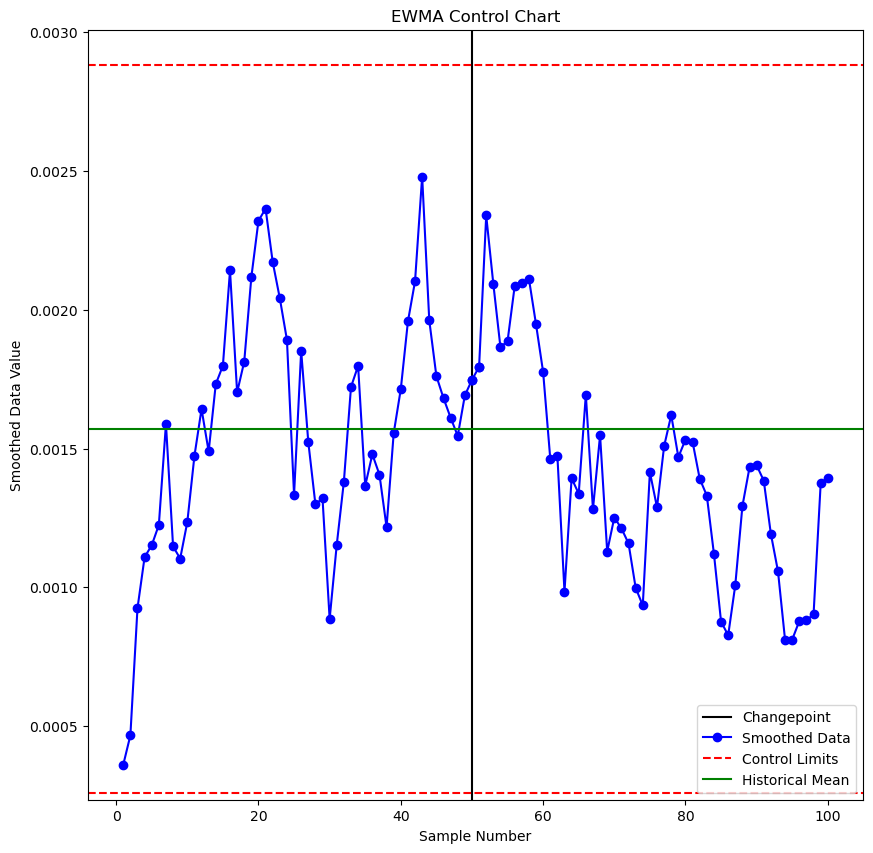

(0, [])

In [62]:
exponential_smoothing_control_chart(evaluation_losses_reg,train_losses_reg,change = 50, alpha = .2)
